# Dipole Study

This intends to reproduce the study presented in http://dmtn-007.lsst.io/en/latest/. In contrast to that study, we are not simulating real dipoles, but using the objects classified as dipoles with the naive flux algorithm. Thus, we cannot fix the flux of the objects and our plots are not comparable in all levels to the one in the document.

In [109]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9
import DiaSourceTools as DSTools

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

import numpy as np

from astropy.table import Table

import sncosmo

import os

import matplotlib.pyplot as plt

import lsst.afw.display.utils as displayUtils

%matplotlib inline

Dipoles were obtaining using the naive measurements after performing the image difference. (Which means, the 2/3 comparison using the naivePSFFlux stored in the DIASources.

A file was generated for every visit (covering all the field). The next line reads all the catalogs and creates a single catalog with all the dipole data.

There are 149410 dipoles in this test.

In [118]:
DIR="/renoir_data_02/jpreyes/lsst_data"
dcats=os.listdir(DIR+"/dipoles_catalogs")
dipoles = None

#afwTable.SourceCatalog.readFits(DIR+"/dipoles_catalogs/"+dcats[0])
for dcat in dcats:
    if dipoles == None:
        dipoles = afwTable.SourceCatalog.readFits(DIR+"/dipoles_catalogs/"+dcat)
    else:
        dipoles.extend(afwTable.SourceCatalog.readFits(DIR+"/dipoles_catalogs/"+dcat))


In [119]:
len(dipoles)

149410

In [22]:
import lsst.meas.algorithms.detection as sDet

#DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_v11/"
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")

dataId = {'visit': 836493, 'filter':'r' , 'ccd':14}
diaSrcs = butler.get("deepDiff_diaSrc", dataId)
diffExp = butler.get("deepDiff_differenceExp", dataId)
#sciExp  = butler.get("calexp", {"visit":836493, "ccd":14, "filter":"r"})
#tmpExp = butler.get("deepDiff_warpedExp", {"visit":836493, "ccd":14, "filter":"r"})
#bgConf = sDet.BackgroundConfig()
#background,tmpExp = sDet.estimateBackground(tmpExp,bgConf,True)

In [26]:
#bbox = diffExp.getBBox()
#bbox.contains()

In [33]:
def get_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))

As we intend to plot the lobe distance vs the flux value frequency, it is necessary to have the lobes centroid coordinates. Such information is still incomplete in almost half the dipoles.

In [120]:
distances = []
fluxes = []
for source in dipoles:
    x1 = source.get("ip_diffim_PsfDipoleFlux_pos_centroid_x")
    y1 = source.get("ip_diffim_PsfDipoleFlux_pos_centroid_y")
    x2 =  source.get("ip_diffim_PsfDipoleFlux_neg_centroid_x")
    y2 = source.get("ip_diffim_PsfDipoleFlux_neg_centroid_y")
    
    pos = source.get("ip_diffim_NaiveDipoleFlux_pos_flux")
    neg = np.abs(source.get("ip_diffim_NaiveDipoleFlux_neg_flux"))
    tot = pos+neg
    pos_per = pos/tot
    neg_per = neg/tot

    #print pos_per, neg_per
    
    if np.isnan(x1) == False and np.isnan(y1) == False and np.isnan(x2) == False and np.isnan(y2) == False:
        distances.append(get_distance(x1,y1,x2,y2))
        fluxes.append((pos_per, neg_per))
print len(distances)

66017


In [121]:
max_d = np.ceil(np.max(distances))
print max_d

297.0


This plot shows the relation between the distance of lobes and the distribution of relative flux contributed by negative (red) and positive lobes (blue). The distances are approximated to integers, and independent histograms are plotted in terms of relative value for the slot (this means that the maximum value of a give histogram is equal to half the distance between two ticks on the X axis(.

The plot shows that, dipoles with smaller separations are more consistent than dipoles further appart. Thus, distributions for closer dipoles depict lobes that contribute more or less the same amount of flux, whereas dipoles with bug separations can oscilate on any range and therefore, can point to non-dipole elements like misclassified fringes.

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in divide
/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in divide


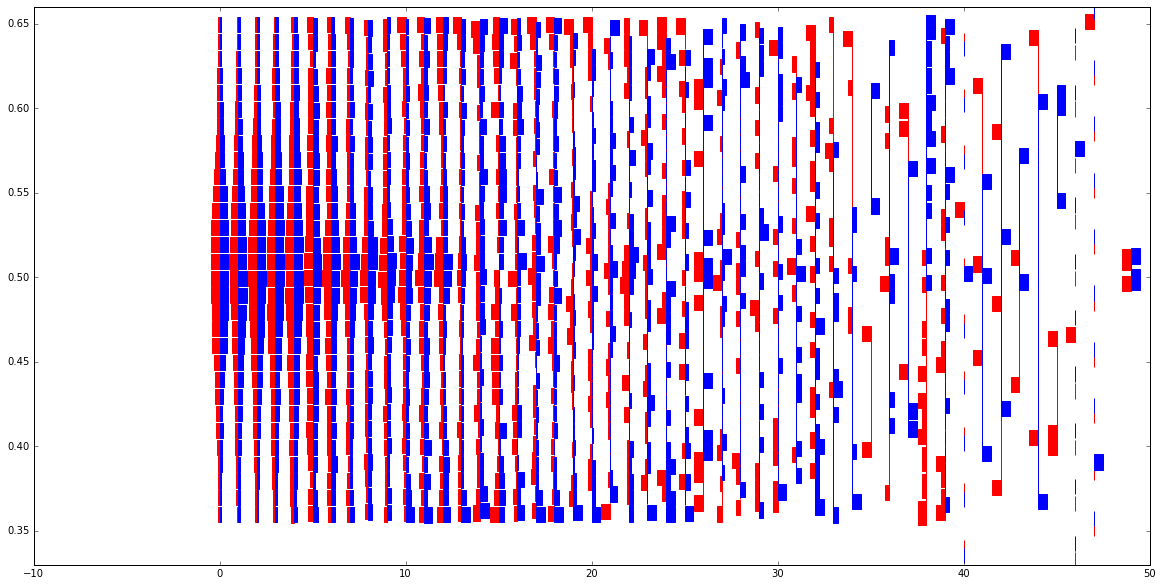

In [127]:
plt.figure(figsize=(20,10))
#for n in range(10, 11):
for n in range(0, 50):
    poss = []
    negs = []
    for i, distance in enumerate(distances):
        if distance < n+1 and distance > n:
            poss.append(fluxes[i][0])
            negs.append(fluxes[i][1])
    #plt.hist(negs, bins=30)
    #plt.show()
    y, vals = np.histogram(negs, bins=30)
    y_p, vals_p = np.histogram(poss, bins=30)
    #plt.gca().invert_yaxis()
    #plt.hist(poss, bins=30)
    bincenters = 0.5*(vals[1:]+vals[:-1])
    bincenters_p = 0.5*(vals_p[1:]+vals_p[:-1])

    max_y = 2.1*float(max(max(y), max(y_p)))

    plt.barh(bincenters, -y/max_y, height= 0.009,  color='red', left=n, edgecolor="red")
    plt.barh(bincenters_p, y_p/max_y, height= 0.009, left=n, edgecolor="blue")
    plt.ylim(ymin=0.33, ymax=0.66)

In [ ]:
#test_stamp = dif_stamp.clone()
mosaic_corr_dif = displayUtils.Mosaic(gutter=5, background=3, mode="square")

for i, source in enumerate(dipoles):
    try:
        test_stamp = DSTools.get_stamp(source, diffExp)
        test_stamp = test_stamp.clone()

        mask  = test_stamp.getMaskedImage().getMask()
        mask &= ~(mask.getPlaneBitMask("DETECTED") | mask.getPlaneBitMask("DETECTED_NEGATIVE"))

        schema = afwTable.SourceTable.makeMinimalSchema()

        #DipoleMeasurementTask.algorithms.names.add('base_PeakLikelihoodFlux')
        DMTask = DipoleMeasurementTask(schema=schema, algMetadata=algMetadata)

        table = afwTable.SourceTable.make(schema)

        config = SourceDetectionTask.ConfigClass()
        config.thresholdPolarity = "both"
        config.thresholdValue = 5.5
        config.reEstimateBackground = False
        config.thresholdType = "pixel_stdev"



        detectionTask = SourceDetectionTask(config=config, schema=schema)

        table = afwTable.SourceTable.make(schema)
        #sources = detectionTask.run(table, exposure, sigma=2).sources
        results = detectionTask.makeSourceCatalog(table=table, exposure=test_stamp , doSmooth=not False )
        DMTask.run(results.sources, test_stamp)
        print "----" + str(i) +"------"
        print len(results.fpSets.positive.getFootprints())
        print len(results.fpSets.negative.getFootprints())

        mosaic_corr_dif.append(test_stamp.getMaskedImage(), label = str(DSTools.get_naive_dipole_probability(source))+"--"+str(i))
    except Exception, e:
        print e

#mosaic_corr_dif.makeMosaic(frame=6, title="mosaic_dif_corrected")
ds9.setMaskTransparency(100, frame=6)

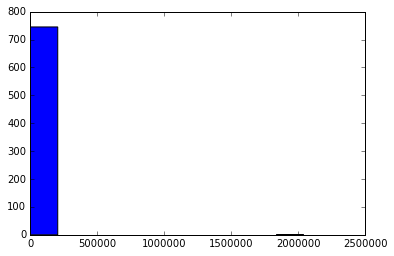

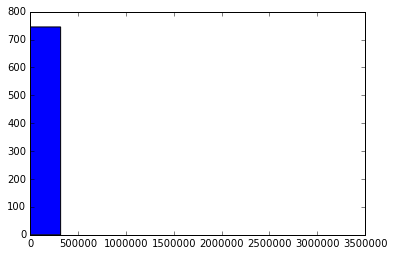

In [58]:
plt.hist(negatives)
plt.show()
plt.hist(positives)
plt.show()

(array([ 286.,    1.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    2.]),
 array([    4.99593112,   151.48724001,   297.97854889,   444.46985777,
          590.96116665,   737.45247553,   883.94378442,  1030.4350933 ,
         1176.92640218,  1323.41771106,  1469.90901995]),
 <a list of 10 Patch objects>)

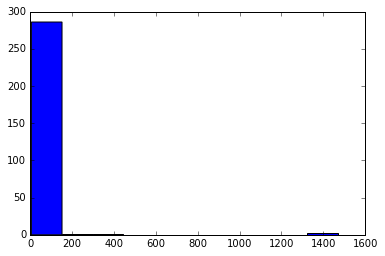

In [31]:
plt.hist(fluxes)
plt.hist(distances)

In [18]:
x1 = source.get("ip_diffim_NaiveDipoleCentroid_pos_x")
y1 = source.get("ip_diffim_NaiveDipoleCentroid_pos_y")
x2 =  source.get("ip_diffim_NaiveDipoleCentroid_neg_x")
y2 = source.get("ip_diffim_NaiveDipoleCentroid_neg_y")

print distance(x1,y1,x2,y2)

16.5098551802
